In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor()
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor()
)

In [3]:
len(train_data)

60000

Image shape : torch.Size([1, 28, 28])
Permuted Image shape : torch.Size([28, 28, 1])
Label : 7


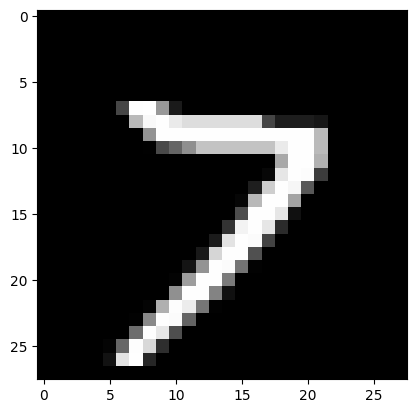

In [4]:
img, label = train_data[3423]
print(f"Image shape : {img.shape}")
print(f"Permuted Image shape : {img.permute(1, 2, 0).shape}")
print(f"Label : {label}")
plt.imshow(img.permute(1, 2, 0), cmap = 'gray')

Label : 5


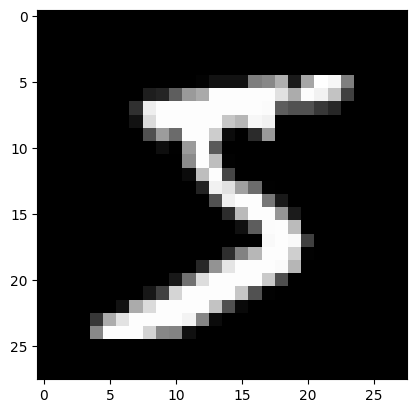

In [5]:
img, label = train_data[0]
plt.imshow(img[0], cmap = 'gray')
print(f"Label : {label}")

In [6]:
val_size = 10000
train_size = len(train_data) - val_size
train_ds, val_ds = random_split(train_data, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [7]:
batch_size = 128
train_dataloader = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dataloader = DataLoader(val_ds, batch_size * 2, num_workers = 2, pin_memory = True)

Image shape : torch.Size([128, 1, 28, 28])


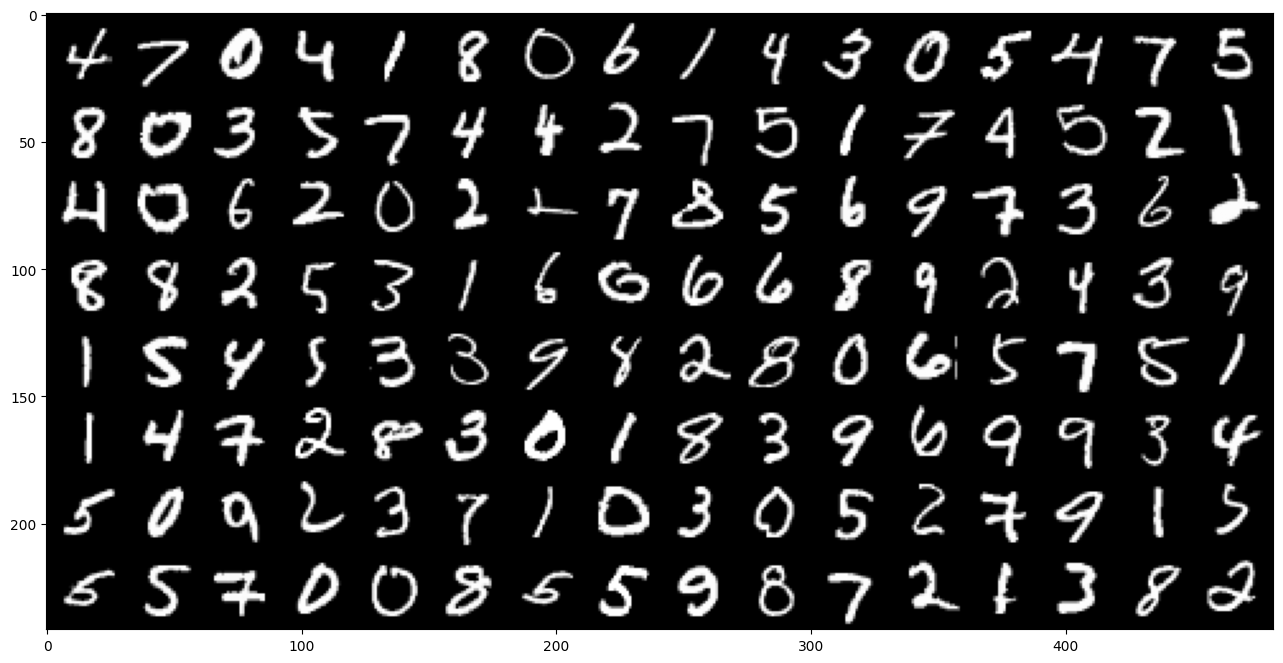

In [8]:
for images, label in train_dataloader:
    print(f"Image shape : {images.shape}")
    plt.figure(figsize=(16, 8))
    plt.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
    break

In [9]:
for images, labels in train_dataloader:
    print(f"images.shape : {images.shape}")
    inputs = images.reshape(-1, 784)
    print(f"inputs.shape : {inputs.shape}")
    break

images.shape : torch.Size([128, 1, 28, 28])
inputs.shape : torch.Size([128, 784])


In [10]:
input_size = inputs.shape[-1]
hidden_size = 32

In [11]:
layer1 = nn.Linear(input_size, hidden_size)

In [12]:
layer1_outputs = layer1(inputs)
print(f"layer1_outputs.shape : {layer1_outputs.shape}")

layer1_outputs.shape : torch.Size([128, 32])


In [13]:
layer1_outputs_direct = torch.matmul(inputs, layer1.weight.t()) + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [14]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

In [15]:
relu_layer1_outputs = F.relu(layer1_outputs)
print(f"min(layer1_outputs) : {torch.min(layer1_outputs).item()}")
print(f"min(relu_layer1_outputs) : {torch.min(relu_layer1_outputs).item()}")

min(layer1_outputs) : -0.7327779531478882
min(relu_layer1_outputs) : 0.0


In [16]:
hidden_size2 = 32
layer2 = nn.Linear(hidden_size, hidden_size2)
layer2_outputs = layer2(relu_layer1_outputs)
print(f"layer2.shape : {layer2_outputs.shape}")
relu_layer2_outputs = F.relu(layer2_outputs)
print(f"min(layer2_outputs) : {torch.min(layer2_outputs).item()}")
print(f"min(relu_layer2_outputs) : {torch.min(relu_layer2_outputs).item()}")

layer2.shape : torch.Size([128, 32])
min(layer2_outputs) : -0.36816251277923584
min(relu_layer2_outputs) : 0.0


In [17]:
output_size = 10
layer3 = nn.Linear(hidden_size2, output_size)
layer3_outputs = layer3(relu_layer2_outputs)
print(f"final output shape : {layer3_outputs.shape}")

final output shape : torch.Size([128, 10])


In [18]:
def accuracy(output, label):
    max_prob, pred_digit = torch.max(output, dim = 1)
    return torch.sum(pred_digit == label).item() / len(label)

In [19]:
class DeepMnistModel(nn.Module):
    def __init__(self, in_size, hidden_size1, hidden_size2, out_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_size, hidden_size1)
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, out_size)

    def forward(self, xb):
        xb = self.flatten(xb)
        layer1 = self.linear1(xb)
        relu_layer1 = F.relu(layer1)
        layer2 = self.linear2(relu_layer1)
        relu_layer2 = F.relu(layer2)
        out = self.linear3(relu_layer2)
        return out

    def training_step(self, batch):
        feature, label = batch
        predicted_label = self(feature)
        loss = F.cross_entropy(predicted_label, label)
        return loss

    def validation_step(self, batch):
        feature, label = batch
        predicted_label = self(feature)
        loss = F.cross_entropy(predicted_label, label)
        val_accuracy = accuracy(predicted_label, label)
        return {
            'val_loss' : loss,
            'val_accuracy' : torch.tensor(val_accuracy)
        }

    def validation_epoch_end(self, val_output):
        batch_losses = [x['val_loss'] for x in val_output]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_acc = [x['val_accuracy'] for x in val_output]
        epoch_acc = torch.stack(batch_acc).mean()
        return {
            'val_loss' : epoch_loss.item(),
            'val_acc' : epoch_acc.item()
        }

    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], val_loss: {result['val_loss']:0.4f}, val_acc: {result['val_acc']:0.4f}")

In [20]:
input_size = 784
hidden_size1 = 64
hidden_size2 = 32
num_classes = 10

In [21]:
model = DeepMnistModel(input_size, hidden_size1, hidden_size2, num_classes)

In [22]:
for i in model.parameters():
    print(i.shape)

torch.Size([64, 784])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [23]:
for images, labels in train_dataloader:
    predicted_labels = model(images)
    preds = F.softmax(predicted_labels, dim = 1)
    loss = F.cross_entropy(predicted_labels, labels)
    print(f"Loss : {loss.item()}")
    break
print(f"predicted_labels.shape : {predicted_labels.shape}")
print(f"Sample predicted label : {preds[-1].data}")

Loss : 2.3089823722839355
predicted_labels.shape : torch.Size([128, 10])
Sample predicted label : tensor([0.0912, 0.1046, 0.0982, 0.1050, 0.0849, 0.1083, 0.0922, 0.1098, 0.0914,
        0.1144])


In [24]:
torch.cuda.is_available()

True

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [26]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

In [27]:
for images, labels in train_dataloader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


In [28]:
class DeviceDataLoader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        for batch in self.dataloader:
            yield to_device(batch, self.device)
    def __len__(self):
        return len(self.dataloader)

In [29]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
val_dataloader = DeviceDataLoader(val_dataloader, device)

In [30]:
for xb, yb in val_dataloader:
    print(f"xb.device : {xb.device}")
    print(f"yb : {yb}")
    break

xb.device : cuda:0
yb : tensor([3, 0, 8, 3, 2, 3, 6, 5, 9, 3, 2, 5, 6, 8, 7, 4, 1, 7, 7, 1, 1, 7, 9, 2,
        4, 6, 7, 7, 8, 0, 0, 0, 6, 1, 7, 5, 9, 8, 1, 7, 3, 4, 2, 6, 3, 2, 1, 6,
        5, 1, 2, 1, 5, 8, 7, 2, 7, 6, 3, 0, 1, 8, 5, 7, 1, 7, 1, 6, 4, 6, 3, 1,
        8, 5, 3, 8, 2, 3, 9, 4, 6, 7, 1, 2, 1, 2, 5, 2, 2, 1, 4, 7, 8, 7, 4, 8,
        9, 7, 9, 1, 2, 6, 5, 0, 6, 5, 1, 9, 8, 5, 2, 5, 6, 6, 5, 6, 2, 5, 7, 8,
        9, 4, 9, 5, 6, 2, 6, 3, 8, 4, 6, 8, 2, 3, 5, 6, 6, 6, 4, 4, 6, 3, 1, 7,
        1, 7, 3, 3, 3, 8, 8, 3, 6, 1, 2, 5, 4, 8, 1, 5, 8, 1, 6, 0, 4, 1, 8, 2,
        2, 8, 8, 7, 1, 8, 8, 8, 3, 5, 6, 3, 8, 6, 9, 8, 1, 3, 6, 4, 2, 2, 7, 0,
        8, 8, 1, 7, 7, 6, 6, 4, 3, 4, 7, 0, 2, 9, 7, 9, 3, 8, 2, 0, 3, 8, 9, 0,
        7, 1, 4, 0, 4, 5, 5, 6, 3, 9, 0, 8, 4, 2, 7, 0, 1, 2, 9, 0, 9, 2, 3, 7,
        2, 1, 9, 2, 9, 9, 7, 9, 5, 9, 4, 9, 4, 8, 7, 2], device='cuda:0')


In [31]:
def evaluate(model, val_dataloader):
    outputs = [model.validation_step(batch) for batch in val_dataloader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, train_dataloader, val_dataloader, model, opt_fn = torch.optim.SGD,):
    opt = opt_fn(model.parameters(), lr)
    history = []
    for epoch in range(epochs):
        # training
        for batch in train_dataloader:
            loss = model.training_step(batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
        # validation
        result = evaluate(model, val_dataloader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [32]:
to_device(model, device)

DeepMnistModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
)

In [33]:
history0 = [evaluate(model, val_dataloader)]
history0

[{'val_loss': 2.304410696029663, 'val_acc': 0.12470702826976776}]

In [34]:
history = fit(50, 0.01, train_dataloader, val_dataloader, model)

Epoch [0], val_loss: 1.9808, val_acc: 0.4565
Epoch [1], val_loss: 1.1048, val_acc: 0.7411
Epoch [2], val_loss: 0.6718, val_acc: 0.8147
Epoch [3], val_loss: 0.5285, val_acc: 0.8473
Epoch [4], val_loss: 0.4612, val_acc: 0.8640
Epoch [5], val_loss: 0.4251, val_acc: 0.8753
Epoch [6], val_loss: 0.3991, val_acc: 0.8837
Epoch [7], val_loss: 0.3801, val_acc: 0.8925
Epoch [8], val_loss: 0.3645, val_acc: 0.8970
Epoch [9], val_loss: 0.3528, val_acc: 0.8997
Epoch [10], val_loss: 0.3434, val_acc: 0.9029
Epoch [11], val_loss: 0.3327, val_acc: 0.9061
Epoch [12], val_loss: 0.3271, val_acc: 0.9079
Epoch [13], val_loss: 0.3198, val_acc: 0.9092
Epoch [14], val_loss: 0.3102, val_acc: 0.9118
Epoch [15], val_loss: 0.3031, val_acc: 0.9144
Epoch [16], val_loss: 0.2963, val_acc: 0.9163
Epoch [17], val_loss: 0.2906, val_acc: 0.9190
Epoch [18], val_loss: 0.2841, val_acc: 0.9192
Epoch [19], val_loss: 0.2773, val_acc: 0.9213
Epoch [20], val_loss: 0.2752, val_acc: 0.9228
Epoch [21], val_loss: 0.2688, val_acc: 0.923

Text(0.5, 1.0, 'Loss vs epochs')

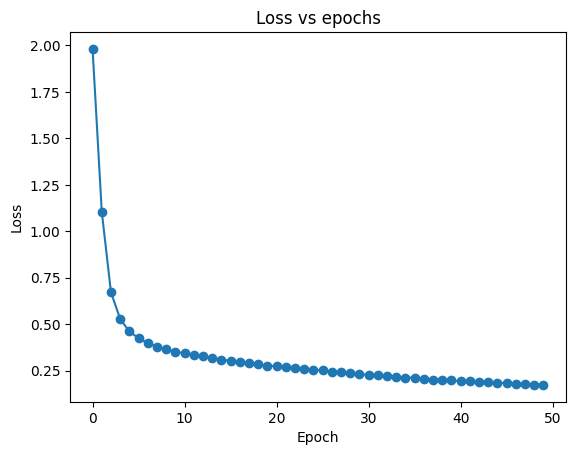

In [35]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs epochs')

Text(0.5, 1.0, 'Accuracy vs Epochs')

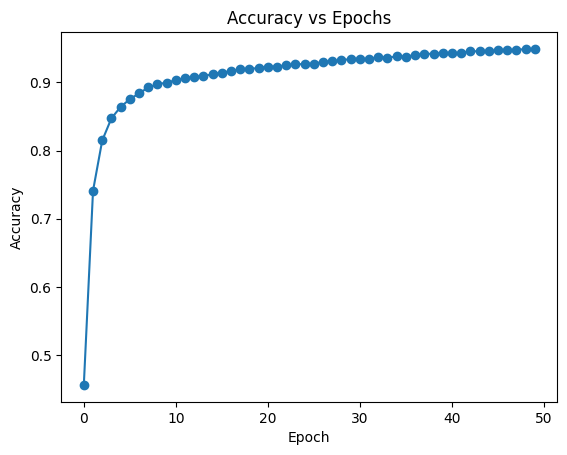

In [36]:
acc = [x['val_acc'] for x in history]
plt.plot(acc, '-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')

In [37]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim = 1)
    return preds[0].item()

Label : 7, Predicted label : 7


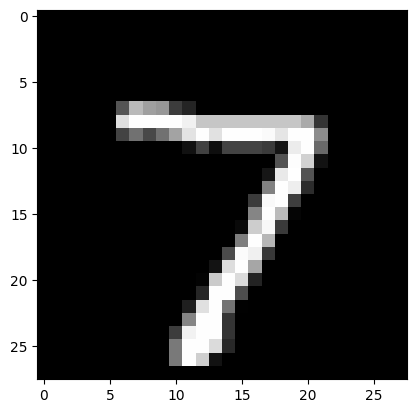

In [38]:
img, label = test_data[0]
plt.imshow(img.permute(1, 2, 0), cmap = 'gray')
print(f"Label : {label}, Predicted label : {predict_image(img, model)}")

Label : 2, Predicted label : 2


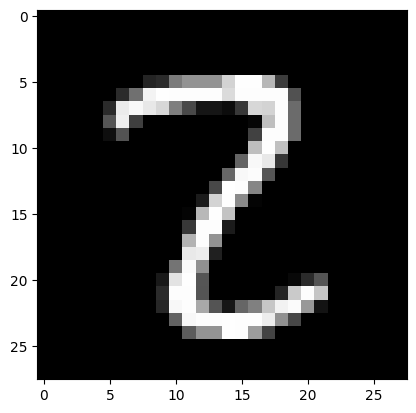

In [39]:
img, label = test_data[1839]
plt.imshow(img.permute(1, 2, 0), cmap = 'gray')
print(f"Label : {label}, Predicted label : {predict_image(img, model)}")

Label : 9, Predicted label : 9


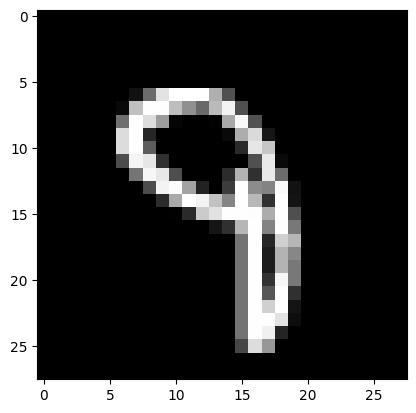

In [40]:
img, label = test_data[193]
plt.imshow(img.permute(1, 2, 0), cmap = 'gray')
print(f"Label : {label}, Predicted label : {predict_image(img, model)}")

In [41]:
test_dataloader = DeviceDataLoader(DataLoader(test_data, batch_size = 256), device)
test_result = evaluate(model, test_dataloader)
print(test_result)

{'val_loss': 0.1525697261095047, 'val_acc': 0.955761730670929}


In [42]:
torch.save(model.state_dict(), 'mnist_ann.pth')

In [43]:
model.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.0322,  0.0322,  0.0016,  ..., -0.0338,  0.0296,  0.0325],
                      [ 0.0350, -0.0264,  0.0036,  ..., -0.0091, -0.0264,  0.0147],
                      [-0.0226, -0.0264, -0.0338,  ..., -0.0103,  0.0048, -0.0330],
                      ...,
                      [-0.0002,  0.0297,  0.0237,  ...,  0.0127,  0.0013, -0.0187],
                      [-0.0346,  0.0135,  0.0167,  ...,  0.0299, -0.0013, -0.0330],
                      [-0.0064,  0.0025,  0.0329,  ..., -0.0117, -0.0232, -0.0116]],
                     device='cuda:0')),
             ('linear1.bias',
              tensor([ 0.0251,  0.0053, -0.0384, -0.0140, -0.0391, -0.0602, -0.0136,  0.0323,
                      -0.1584, -0.0061,  0.0634,  0.1517, -0.0094, -0.0065, -0.0424,  0.1327,
                       0.0478, -0.0268, -0.0214,  0.0195,  0.0254,  0.0137, -0.0366,  0.0557,
                      -0.0379,  0.0640,  0.0660,  0.0778,  0.0582, -0.0453,  0.1594,

In [44]:
model1 = DeepMnistModel(input_size, hidden_size1, hidden_size2, num_classes)
model1.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.0297,  0.0086, -0.0198,  ..., -0.0348,  0.0261,  0.0240],
                      [ 0.0197, -0.0069,  0.0355,  ..., -0.0073,  0.0322, -0.0052],
                      [ 0.0071,  0.0337,  0.0250,  ..., -0.0041,  0.0075,  0.0225],
                      ...,
                      [ 0.0264, -0.0210,  0.0327,  ...,  0.0355,  0.0032, -0.0032],
                      [ 0.0275,  0.0157, -0.0201,  ..., -0.0294, -0.0272, -0.0084],
                      [ 0.0052, -0.0124,  0.0136,  ..., -0.0128,  0.0041,  0.0270]])),
             ('linear1.bias',
              tensor([-0.0018, -0.0007, -0.0275, -0.0125, -0.0344,  0.0260, -0.0064,  0.0032,
                       0.0357,  0.0299,  0.0357,  0.0197,  0.0047,  0.0079, -0.0247, -0.0015,
                       0.0317, -0.0293,  0.0276,  0.0125,  0.0136,  0.0065, -0.0251,  0.0028,
                      -0.0046,  0.0214,  0.0089,  0.0209,  0.0192,  0.0077, -0.0117, -0.0355,
                       0.000

In [45]:
model1.load_state_dict(torch.load('mnist_ann.pth'))
print(model1.state_dict())

OrderedDict([('linear1.weight', tensor([[ 0.0322,  0.0322,  0.0016,  ..., -0.0338,  0.0296,  0.0325],
        [ 0.0350, -0.0264,  0.0036,  ..., -0.0091, -0.0264,  0.0147],
        [-0.0226, -0.0264, -0.0338,  ..., -0.0103,  0.0048, -0.0330],
        ...,
        [-0.0002,  0.0297,  0.0237,  ...,  0.0127,  0.0013, -0.0187],
        [-0.0346,  0.0135,  0.0167,  ...,  0.0299, -0.0013, -0.0330],
        [-0.0064,  0.0025,  0.0329,  ..., -0.0117, -0.0232, -0.0116]])), ('linear1.bias', tensor([ 0.0251,  0.0053, -0.0384, -0.0140, -0.0391, -0.0602, -0.0136,  0.0323,
        -0.1584, -0.0061,  0.0634,  0.1517, -0.0094, -0.0065, -0.0424,  0.1327,
         0.0478, -0.0268, -0.0214,  0.0195,  0.0254,  0.0137, -0.0366,  0.0557,
        -0.0379,  0.0640,  0.0660,  0.0778,  0.0582, -0.0453,  0.1594, -0.0304,
        -0.0267,  0.1069,  0.0311, -0.0413,  0.0172, -0.0273, -0.0426,  0.0356,
        -0.0304,  0.0117,  0.0598,  0.0197, -0.0093, -0.0293, -0.0530,  0.0301,
        -0.0737,  0.0198,  0.0587, 